In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from tqdm.notebook import tqdm
from tqdm import tqdm

#not in scope of this course
## ------------- this changed to EMNIST  ------------ ##
from torchvision.datasets import EMNIST
import torchvision.transforms as T
from torch.utils.data import DataLoader


In [27]:
## ------------- this changed to EMNIST with the addition of split becuase it is a requierd arg ------------ ##
train_dataset = EMNIST(".", download = True, train = True, split = "letters" , transform = T.ToTensor())
test_dataset = EMNIST(".", download = True, train = False, split = "letters",  transform = T.ToTensor())


In [28]:
print("Class names:", train_dataset.classes)
print("\nNumber of classes:", len(train_dataset.classes))
print("\nClass to index:", train_dataset.class_to_idx)

print("\ntrain_dataset.data.shape",train_dataset.data.shape)
print("\ntest_dataset.data.shape",test_dataset.data.shape)



Class names: ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Number of classes: 27

Class to index: {'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

train_dataset.data.shape torch.Size([124800, 28, 28])

test_dataset.data.shape torch.Size([20800, 28, 28])


In [29]:
bs = 64

train_loader = DataLoader(train_dataset, batch_size = bs)
test_loader = DataLoader(test_dataset, batch_size = bs)



print("Number of batches for train: ",len(train_loader))
print("Batch size for train: ",train_loader.batch_size)

print("Number of batches for test: ",len(test_loader))
print("Batch size for test: ",test_loader.batch_size)

print()
for images, labels in train_loader:
    print("Images: ",images.shape)
    print("Labels: ",labels.shape)
    break



Number of batches for train:  1950
Batch size for train:  64
Number of batches for test:  325
Batch size for test:  64

Images:  torch.Size([64, 1, 28, 28])
Labels:  torch.Size([64])


## $\color{lightblue}{\text{Why from 28×28×1 to 1×28×28?}}$
## $\color{lightblue}{\text{PyTorch convention is (batch_size, channels, height, width)}}$

# Tasks
#1) Create at least 4 layers NN to classify the dataset     
#2) Train the neural network on train dataset       
#3) Show the training loss      
#4) Calculate the accuracy on test set      
#5) Show a few incorrectly classified samples       
#6) Calculate class-wise accuracy (implement the function yourself)     

# Neural Network

---



In [30]:
# # Define the neural network
# class My_NN(nn.Module):
#     def __init__(self, ni, nh1, nh2, nh3, no):
#         super(My_NN, self).__init__()
#         self.layer1 = nn.Linear(ni, nh1)
#         self.layer2 = nn.Linear(nh1, nh2)
#         self.layer3 = nn.Linear(nh2, nh3)
#         self.layer4 = nn.Linear(nh3, no)

#     def forward(self, x):
#         x = x.view(-1, ni)
#         x = F.sigmoid(self.layer1(x))
#         x = F.sigmoid(self.layer2(x))
#         x = F.sigmoid(self.layer3(x))
#         x = self.layer4(x)
#         return x

#---------------------------------------------------------------$$
##      sigmoid doesn't give good accuracy score , 10%
#---------------------------------------------------------------$$

In [31]:
# Define the neural network
class My_NN(nn.Module):
    def __init__(self, ni, nh1, nh2, nh3, no):
        super(My_NN, self).__init__()
        self.layer1 = nn.Linear(ni, nh1)
        self.layer2 = nn.Linear(nh1, nh2)
        self.layer3 = nn.Linear(nh2, nh3)
        self.layer4 = nn.Linear(nh3, no)

    def forward(self, x):
        # before x.view = [64, 1, 28, 28]
        x = x.view(-1, ni)  # reshape to [64, 28*28]
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        return x

#---------------------------------------------------------------$$
##      i think both leaky_relu and relu give the same results
#---------------------------------------------------------------$$


# Hyper prameters

---



In [32]:
# Hyper prameters
## ------------- changed the input ------------ ##
ni = 28 *28         # 28 * 28 * 1 Input layer size
## ------------- changed the input ------------ ##

nh1 = 512         # Hidden layer 1 size
nh2 = 256          # Hidden layer 2 size
nh3 = 128          # Hidden layer 3 size

## ------------- changed the output ------------ ##
no = 27           # Output layer size (number of classes for EMNIST)
## ------------- changed the output ------------ ##

# cuda:0 refers to first GPU, fallback to CPU if no GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

lr = 0.01
mm = 0.5


epochs = 25
ls = []


cuda:0


In [33]:
# Create the neural network
model = My_NN(ni, nh1, nh2, nh3, no).to(device)


# Loss and Optim

---



In [34]:
# Define loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)
#---------------------------------------------------------------------------------------------------------------------------------------$$
#_______  using Adam leads to oscillation in the loss, and it's quite abnormal , _______
#_______  with SGD and relu about 48 acuracy can be achieved with 15 epochs and 0.01 learning_rate _______
#----------------------------------------------------------------------------------------------------------------------------------------$$


# Training

---



```python  

%%time
total_loss = 0.0

for epoch in range(epochs):
    print(f'Epoch [{epoch+1}/{epochs}] started...')
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device('cuda:0')
        optimizer.zero_grad()  # zero the gradients
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()  # compute gradients
        optimizer.step()  # update the weights -lr * gradient
        
        total_loss += loss.item()
    
    loss = total_loss / ((epoch + 1) * len(train_loader))
    ls.append(loss)
    print(f'Epoch [{epoch+1}/{epochs}] completed. Loss: {loss:.4f}')

```    

```
u can just use the above code if you dont want the progress bar
```

In [35]:
%%time

## --------- for pb = (progress bar) u can remove it ---------
# Calculate total steps (batches * epochs) for the progress bar
pbar = tqdm(total = epochs * len(train_loader), desc='Training')
## --------- for pb = (progress bar) u can remove it ---------


total_loss = 0.0

for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device('cuda:0')
        optimizer.zero_grad()  # zero the gradients
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()  # compute gradients
        optimizer.step()  # update the weights -lr * gradient
        total_loss += loss.item()


        ## --------- for pb = (progress bar) u can remove it ---------
        current_loss = total_loss / (pbar.n + 1)  # pbar.n tracks number of completed steps
        pbar.update(1)  # Increment progress by 1 step
        pbar.set_postfix({'epoch': f'{epoch+1}/{epochs}', 'loss': f'{current_loss:.4f}'})
        ## --------- for pb = (progress bar) u can remove it ---------

    # Calculate average loss for the epoch
    loss = total_loss / ((epoch + 1) * len(train_loader))
    ls.append(loss)

pbar.close()  # Clean up the progress bar

Training: 100%|██████████| 48750/48750 [11:04<00:00, 73.36it/s, epoch=25/25, loss=0.3885]

CPU times: user 9min 54s, sys: 18.5 s, total: 10min 13s
Wall time: 11min 4s


# Loss plot

---



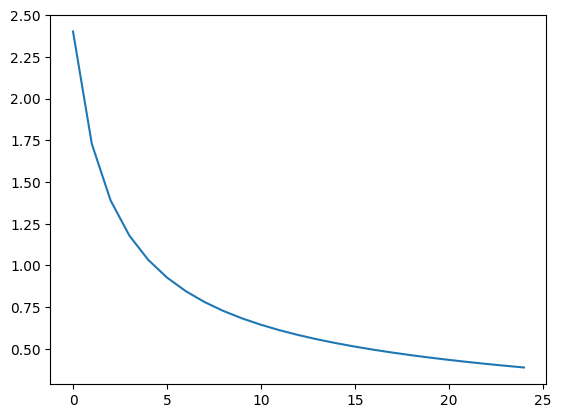

In [36]:
# Plot the training loss
plt.plot(ls)

# Accuracy

---



```python
the following is called logits, or raw score:

[-1.2, 2.5, 0.8, -0.3, 1.1, -0.5, 0.9, 1.7, -0.2, 0.4]
  │    │    │     │    │     │    │    │     │    └── truck
  │    │    │     │    │     │    │    │     └──── ship
  │    │    │     │    │     │    │    └────── horse
  │    │    │     │    │     │    └───────── frog
  │    │    │     │    │     └──────────── dog
  │    │    │     │    └────────────── deer
  │    │    │     └──────────────── cat
  │    │    └─────────────────── bird
  │    └──────────────────── automobile (highest score: 2.5)
  └───────────────────── airplane
  ```

  argmax basically looks for the higst value and returns to you its index , in this case :
  ```
  index = 1
  ```


In [37]:
# Evaluate the accuracy on the test set
model.eval()
correct = 0  # Initialize the number of correctly predicted samples
total = 0    # Initialize the total number of samples

# Disable gradient computation during inference
with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the device('cuda:0')
      outputs = model(inputs)  # Forward pass
      predicted_labels = torch.argmax(outputs, dim=1)  # Get predicted labels by finding the index of the maximum value
      correct += torch.sum(predicted_labels == labels).item()  # Count the number of correct predictions
      total += labels.size(0)  # Update the total number of samples

accuracy = correct / total  # Calculate accuracy
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')  # Print the accuracy in percentage


Accuracy on Test Set: 90.56%


# Mispredicted  and correctly predicted labels

---




Incorrect classified samples:


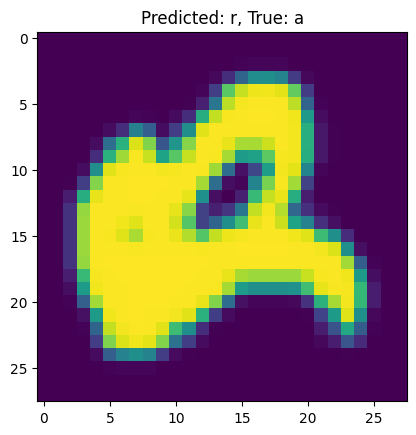

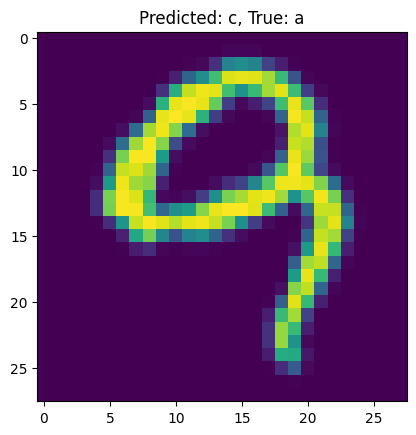

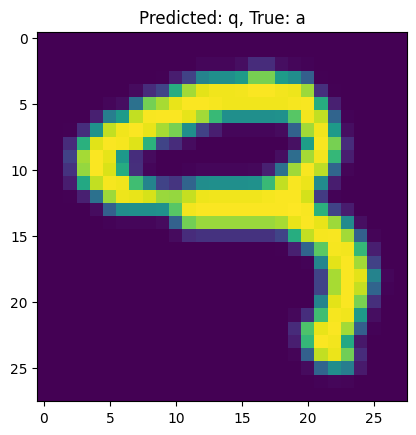


Correct classified samples:


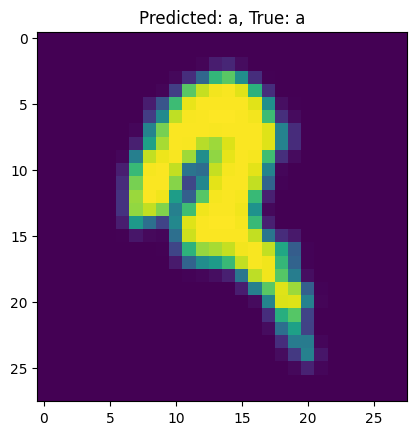

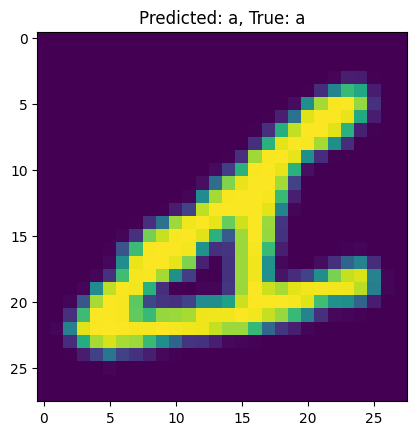

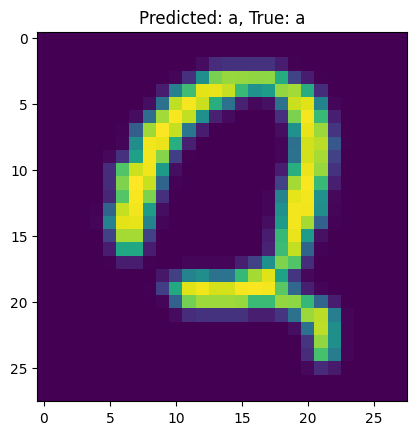

In [38]:
## ------------- changed the classes------------ ##
class_names = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
## ------------- changed the classes------------ ##

model.eval()
samples = {'correct': [], 'incorrect': []}

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        predicted = torch.argmax(model(inputs), dim=1)

        for i, (pred, label) in enumerate(zip(predicted, labels)):
            category = 'correct' if pred == label else 'incorrect'
            samples[category].append((inputs[i], pred.item(), label.item()))

for category in ['incorrect', 'correct']:
    print(f"\n{category.capitalize()} classified samples:")
    for image, pred, true in samples[category][:3]:
        plt.imshow(T.ToPILImage()(image))
        plt.title(f'Predicted: {class_names[pred]}, True: {class_names[true]}')
        plt.show()


# Clss_wise accuracy

---



In [39]:
# Calculate class-wise accuracy
model.eval()

## ------------- changed to 27 becuase we have 27 calsses ------------ ##
class_correct = torch.zeros(27, device=device)
class_total = torch.zeros(27, device=device)
## ------------- changed to 27 becuase we have 27 calsses ------------ ##

with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      predicted = torch.argmax(model(inputs), dim=1)
      ## ------------- changed to 27 becuase we have 27 calsses ------------ ##
      for label in range(27):
        mask = (labels == label)
        class_total[label] += mask.sum()
        class_correct[label] += ((predicted == labels) & mask).sum()

for i, (correct, total) in enumerate(zip(class_correct, class_total)):
    acc = (correct / total * 100).item()
    print(f'Accuracy of class {i}: {acc:.2f}%')


Accuracy of class 0: nan%
Accuracy of class 1: 90.62%
Accuracy of class 2: 87.38%
Accuracy of class 3: 96.00%
Accuracy of class 4: 91.50%
Accuracy of class 5: 93.00%
Accuracy of class 6: 91.75%
Accuracy of class 7: 76.88%
Accuracy of class 8: 92.12%
Accuracy of class 9: 79.50%
Accuracy of class 10: 89.62%
Accuracy of class 11: 90.62%
Accuracy of class 12: 70.75%
Accuracy of class 13: 97.25%
Accuracy of class 14: 91.88%
Accuracy of class 15: 94.38%
Accuracy of class 16: 96.62%
Accuracy of class 17: 80.62%
Accuracy of class 18: 88.50%
Accuracy of class 19: 93.38%
Accuracy of class 20: 96.12%
Accuracy of class 21: 93.88%
Accuracy of class 22: 92.88%
Accuracy of class 23: 95.25%
Accuracy of class 24: 92.88%
Accuracy of class 25: 93.88%
Accuracy of class 26: 97.25%
